In [60]:
%pylab inline
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)
pd.options.display.float_format = '£{:,.2f}'.format


month = '2016-09-01'

Populating the interactive namespace from numpy and matplotlib


# Top ccg-presentation savings

The SQL for this is abstracted into the `price_utils` library, q.v. for details.

We normalise prescriptions to their generic equivalent.  See [the README](https://github.com/ebmdatalab/price-per-dose/blob/master/README.md) for details.

The following is sorted by possible savings at the top decile. It tells us that CCG 13T  had the single biggest saving opportunity: to save £33,600 on its purchase of 8258 flu vaccines. It paid £9.92 per dose, when the lowest decile paid £5.85 per dose.

It is limited to the top 1000 CCG-presentation tuples.

In [61]:
top_1000_ccg = price_utils.get_savings(group_by='pct', month=month, limit=1000, sql_only=False)

In [64]:
top_1000_ccg.head()

,bnf_presentation,bnf_chemical,pct,generic_presentation,category,avg_brand_count_per_practice,lowest_decile,quantity,price_per_dose,possible_savings
0,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,04G,0601060D0AAA0A0,NP8,£10.16,£0.20,801392,£0.27,"£59,575.16"
1,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,11J,0601060D0AAA0A0,NP8,£12.90,£0.20,827490,£0.26,"£55,404.51"
2,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,99P,0601060D0AAA0A0,NP8,£11.61,£0.20,931673,£0.25,"£53,788.66"
3,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,11X,0601060D0AAA0A0,NP8,£14.05,£0.20,594981,£0.29,"£53,385.72"
4,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,03N,0601060D0AAA0A0,NP8,£11.29,£0.20,596567,£0.28,"£50,894.12"


How do the savings break down by Tariff Part VIII?

In [65]:
top_1000_ccg.to_csv("ccgs-%s.csv" % month)
top_1000_ccg.groupby('category')['possible_savings'].sum()

category
A      £216,141.20 
C     £5,968,569.41
M      £572,976.23 
NP8   £5,193,607.47
Name: possible_savings, dtype: float64

What are the top chemicals?

In [73]:
top_1000_ccg.groupby('bnf_chemical')['possible_savings'].sum().sort_values(ascending=False).head()


bnf_chemical
Glucose Blood Testing Reagents   £3,674,643.31
Fluticasone Propionate (Inh)     £1,978,003.35
Budesonide                       £1,395,654.15
Pregabalin                       £1,264,142.63
Influenza                        £1,236,374.94
Name: possible_savings, dtype: float64

## Grouped by CCG

The same data as above, but grouped by CCG rather than CCG-presentation pairs.

In [74]:
by_ccg = top_1000_ccg.groupby('pct')['possible_savings'] \
  .agg({'Count': 'count', 'Total savings': 'sum'}).sort_values('Total savings', ascending=False)
by_ccg.head()

,Count,Total savings
pct,,
11J,21,"£346,921.95"
99P,17,"£302,115.17"
13P,18,"£288,144.71"
09G,17,"£259,940.58"
01H,17,"£251,496.96"


A total of just under £12m of possible savings per month!

In [75]:
by_ccg['Total savings'].sum()

11951294.311695114

## Just focusing on Rich's CCG

It could have saved £300k:

In [76]:
by_ccg.loc('savings_presentations_pct')['99P']

Count               £17.00 
Total savings   £302,115.17
Name: 99P, dtype: float64

The top 5 savings would have been:

In [77]:
reload(price_utils)
asd = price_utils.get_savings(for_entity='99P', month=month, limit=None)

In [78]:
asd.sort_values('possible_savings', ascending=False).head(5)

,bnf_presentation,bnf_chemical,pct,generic_presentation,category,avg_brand_count_per_practice,lowest_decile,quantity,price_per_dose,possible_savings
0,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,99P,0601060D0AAA0A0,NP8,£11.61,£0.20,931673,£0.25,"£54,161.33"
1,Budesonide/Formoterol Inh B/A 200/6(120D,Budesonide,99P,0302000K0AAAMAM,C,£2.19,£29.97,5042,£36.58,"£32,770.43"
2,Pregabalin_Cap 300mg,Pregabalin,99P,0408010AEAAAGAG,C,£2.13,£0.80,93796,£1.12,"£29,241.90"
3,Pregabalin_Cap 150mg,Pregabalin,99P,0408010AEAAAEAE,C,£2.21,£0.80,89637,£1.11,"£27,266.16"
4,Fluticasone/Salmeterol_Inh 125/25mcg120D,Fluticasone Propionate (Inh),99P,0302000N0AABFBF,C,£1.63,£26.25,3212,£34.73,"£26,836.25"


In [79]:
# Save it to a cSV

asd.to_csv("99P-full-%s.csv" % month)

# Same thing for practices

In [85]:
reload(price_utils)
top_1000_practice = price_utils.get_savings(group_by='practice',month=month, limit=1000)

In [87]:
top_1000_practice.head(10)


,bnf_presentation,bnf_chemical,practice,pct,generic_presentation,category,avg_brand_count_per_practice,lowest_decile,quantity,price_per_dose,possible_savings
0,"Dalteparin Sod_Inj 25,000u/ml 0.72ml Pfs",Dalteparin Sodium,K84055,10Q,0208010L0AAAIAI,NP8,1,£10.16,110,£137.41,"£13,996.85"
1,Sod Phenylbut_Liq Spec 1.25g/5ml,Sodium Phenylbutyrate,J82034,11A,0908010P0AAAEAE,NP8,1,£1.09,2500,£5.56,"£11,187.72"
2,Trientine Dihydroch_Cap 300mg,Trientine Dihydrochloride,E83638,07M,0908010S0AAACAC,NP8,1,£22.91,400,£49.99,"£10,831.68"
3,Melatonin_Tab 3mg,Melatonin,H82016,09G,0401010ADAABPBP,NP8,2,£0.75,552,£19.26,"£10,219.03"
4,Trientine Dihydroch_Cap 300mg,Trientine Dihydrochloride,F81069,06T,0908010S0AAACAC,NP8,1,£22.91,200,£65.74,"£8,565.84"
5,Sod Chlor_Liq Spec 292.5mg/5ml,Sodium Chloride,B83602,02N,0902012L0AABRBR,NP8,1,£0.06,8000,£1.10,"£8,309.15"
6,Influenza_Vac Inact 0.5ml Pfs,Influenza,H82052,09H,1404000H0AAAFAF,NP8,1,£5.85,1771,£9.94,"£7,243.39"
7,Co-Proxamol_Tab 32.5mg/325mg,Co-Proxamol (Dextroprop HCl/Paracet),M91011,05Y,0407010Q0AAAAAA,NP8,1,£0.70,3672,£2.55,"£6,780.45"
8,"Dalteparin Sod_Inj 25,000u/ml 0.6ml Pfs",Dalteparin Sodium,C82031,04C,0208010L0AAAHAH,NP8,1,£8.47,60,£115.16,"£6,401.77"
9,Influenza_Vac Inact 0.5ml Pfs,Influenza,G83006,07N,1404000H0AAAFAF,NP8,1,£5.85,1500,£9.94,"£6,135.00"


In [88]:

top_1000_practice.to_csv("practices-%s.csv" % month)

# What is the distribution of the easiest cost savings?

For each practice, compute and sum its top three savings, then plot these in a histogram.

In [89]:
reload(price_utils)
top_10 = price_utils.top_savings_per_entity(top_n=10, entity='practice')

In [90]:
reload(price_utils)
top_1 = price_utils.top_savings_per_entity(top_n=1, entity='practice', summed=False)
top_1.to_csv("top_saving_for_each_practice_%s.csv" % month)

In [91]:
top_10.describe()

,top_savings_sum
count,"£7,637.00"
mean,"£2,828.06"
std,"£1,875.71"
min,£0.00
25%,"£1,510.26"
50%,"£2,441.62"
75%,"£3,732.34"
max,"£23,335.37"


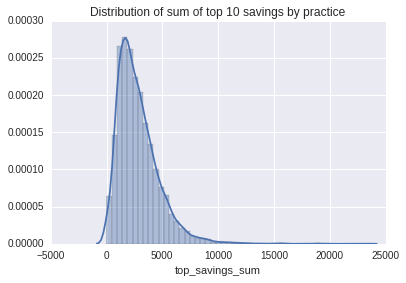

In [92]:
sns.distplot(top_10.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice")
plt.show()

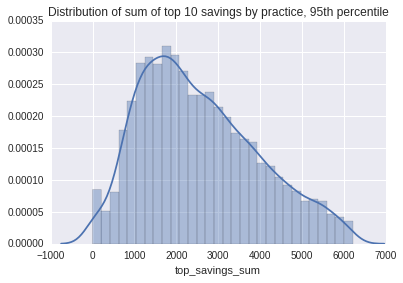

In [93]:
asd = top_10[top_10.top_savings_sum < top_10.top_savings_sum.quantile(.95)]
g = sns.distplot(asd.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice, 95th percentile")
plt.show()

## Same thing, by CCG

In [94]:
reload(price_utils)
top_10_pct = price_utils.top_savings_per_entity(top_n=10, entity='pct')

In [95]:
top_10_pct.describe()

,top_savings_sum
count,£213.00
mean,"£74,544.74"
std,"£41,720.10"
min,£47.38
25%,"£48,804.87"
50%,"£65,017.11"
75%,"£90,894.98"
max,"£257,265.84"


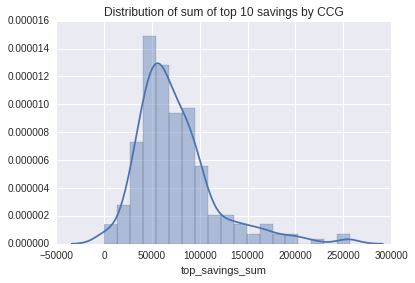

In [96]:
sns.distplot(top_10_pct.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by CCG")
plt.show()

In [97]:
reload(price_utils)
top_1000_product = price_utils.get_savings(group_by='product', month=month, limit=1000)


In [98]:
top_1000_product.head(5)


,bnf_presentation,bnf_chemical,generic_presentation,category,avg_brand_count_per_practice,lowest_decile,quantity,price_per_dose,possible_savings
0,Glucose Blood Testing Reagents,Glucose Blood Testing Reagents,0601060D0AAA0A0,NP8,£12.05,£0.20,57333666,£0.26,"£3,732,787.80"
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,Fluticasone Propionate (Inh),0302000N0AABGBG,C,£2.06,£44.61,158950,£56.59,"£1,866,927.90"
2,Influenza_Vac Inact 0.5ml Pfs,Influenza,1404000H0AAAFAF,NP8,£1.10,£5.85,2055110,£6.62,"£1,652,158.27"
3,Pregabalin_Cap 75mg,Pregabalin,0408010AEAAACAC,C,£1.71,£0.81,5035691,£1.13,"£1,616,023.01"
4,Budesonide/Formoterol Inh B/A 200/6(120D,Budesonide,0302000K0AAAMAM,C,£2.20,£29.97,225338,£36.74,"£1,465,282.03"


## What if every practice enacted all its top 3 savings?

The following shows that there would be £11m of savings, including: £3.4m on blood test strips, £1.1m on vaccines, £1.2m on Fluticasone/Salmeterol inhalers, and £600k on Pregabalin

In [100]:
reload(price_utils)
# A list of all the generic presentations in the top three savings for each practice
df = price_utils.all_presentations_in_per_entity_top_n(top_n=3, entity='practice', month='2016-09-01')

In [101]:
# Total savings if each practice enacted its top three savings
df.top_savings_sum.sum()

11271871.661754351

In [104]:
# The top savings by presentation if each practice enacted its top three savings
by_presentation = df.groupby('presentation').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_presentation.head()

presentation
Glucose Blood Testing Reagents             £3,407,639.15
Influenza_Vac Inact 0.5ml Pfs              £1,139,882.90
Fluticasone/Salmeterol_Inh 250/25mcg120D   £1,079,190.25
Pregabalin_Cap 75mg                         £605,890.60 
Budesonide/Formoterol Inh B/A 200/6(120D    £523,917.35 
Name: top_savings_sum, dtype: float64

In [105]:
# The top savings by chemical if each practice enacted its top three savings
by_subpara = df.groupby('chemical').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_subpara.head(10)

chemical
Glucose Blood Testing Reagents   £3,407,639.15
Fluticasone Propionate (Inh)     £1,219,067.75
Influenza                        £1,139,882.90
Budesonide                        £678,325.00 
Pregabalin                        £609,752.59 
Venlafaxine                       £426,609.27 
Levetiracetam                     £255,212.89 
Colecalciferol                    £233,747.62 
Lamotrigine                       £225,992.93 
Methocarbamol                     £219,536.90 
Name: top_savings_sum, dtype: float64

### And just its top 1 saving?
£5.4 million of savings, mostly on blood testing strips.

In [102]:
reload(price_utils)
# A list of all the generic presentations in the top one savings for each practice
df2 = price_utils.all_presentations_in_per_entity_top_n(top_n=1, entity='practice', month='2016-09-01')

In [103]:
df2.top_savings_sum.sum()

5402408.9908812381

In [106]:
# The top savings by chemical if each practice enacted its top saving
by_chemical2 = df2.groupby('chemical').top_savings_sum.sum().sort_values(inplace=False, ascending=False)
by_chemical2.head(10)

chemical
Glucose Blood Testing Reagents         £2,205,046.64
Influenza                               £618,568.12 
Fluticasone Propionate (Inh)            £395,383.37 
Budesonide                              £138,427.95 
Dalteparin Sodium                       £134,055.24 
Methocarbamol                           £125,781.71 
Colecalciferol                          £125,576.25 
Co-Proxamol (Dextroprop HCl/Paracet)    £115,136.91 
Pregabalin                              £102,316.69 
Venlafaxine                             £100,853.13 
Name: top_savings_sum, dtype: float64

# What are the actions for the top drugs?

1. Switch from *Aviva testing strips (Roche Diabetes Care Ltd)* or *Mobile cassette (Roche Diabetes Care Ltd)* or *Contour Next testing strips (Bayer Diagnostics Manufacturing Ltd)* or *FreeStyle Optium testing strips (Abbott Laboratories Ltd)* to *GlucoRx Nexus testing strips (GlucoRx Ltd)* or *WaveSense JAZZ testing strips (AgaMatrix Europe Ltd)*
2. Switch from *Seretide 250 Evohaler* to *Sirdupla 25micrograms/dose / 250micrograms/dose inhaler* 
3. Switch from *Fluarix Tetra vaccine suspension for injection 0.5ml pre-filled syringes* to *Influvac Sub-unit vaccine suspension for injection 0.5ml pre-filled syringes*
4. Switch from *Lyrica 75mg capsules* to *Alzain 75mg capsules*
5. Switch from *Symbicort 200/6 Turbohaler* to *DuoResp Spiromax 160micrograms/dose / 4.5micrograms/dose dry powder inhaler*

## What reasons are there for not switching?

There are a number of costs relating to switching, including:

* With device-based drugs, patients require training in new devices
* Patients are reluctant to accept change when they perceive a certain brand as working
* GPs are reluctant to accept change when they see it as continuous background pressure (e.g. moving targets, ever-cheaper products becoming available)
* Possibly unfounded views among HCPs that alternatives are not clinincally equivalent

For example, regarding glucose testing switches, Rich said:

> Because it's not a simple switch.  We have done it where we can, but it requires patients being taught how to use the new meters, and we have to get new meters.  It's also a leapfrogging issue - we've already switched a good proportion to cheaper test strips (e.g. GlucoRx) and then another cheaper one comes in.  Also, there is a reluctance with diabetes nurses to change meters in type 1 diabetics, who use the majority of the strips.  Whether there's an evidence base for that is another matter...



## What if practices only enacted cost savings that were at least £1000?

There would still be £3m of savings. Plotting total savings against a minimum threshold shows something close to an exponential dropoff (the closest fit is a 4PL curve with the inflection point relatively close to zero: `y = 2694457 + 35665420*e^(-0.003723744*x)`)

In [107]:
d = {}
for threshold in [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010]:
    d[threshold] = price_utils.cost_savings_at_minimum_for_practice(threshold, month='2016-09-01').top_savings_sum.sum()
d

{10: 45118150.628540531,
 110: 26713863.163539305,
 210: 18438071.583421946,
 310: 13730682.629607689,
 410: 10524624.320174236,
 510: 8338214.171697489,
 610: 6707300.2559314398,
 710: 5463062.1810071366,
 810: 4474951.6117965709,
 910: 3712946.6185247391,
 1010: 3162481.2764979368}

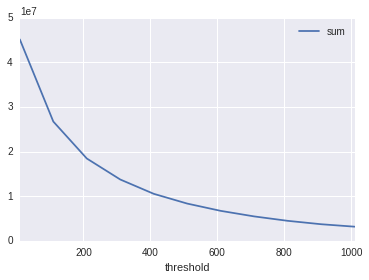

In [108]:
pd.options.display.float_format = None
asd = pd.DataFrame(d.items())
asd.columns = ['threshold', 'sum']
s = asd.sort_values('threshold')
s.plot(x='threshold', y='sum')

## Visualising distributions of drug prices

### 1. Drugs with the greatest saving potential

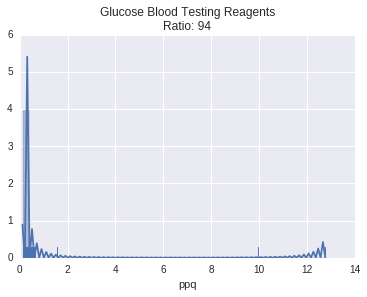

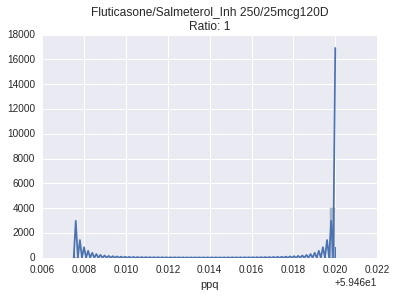

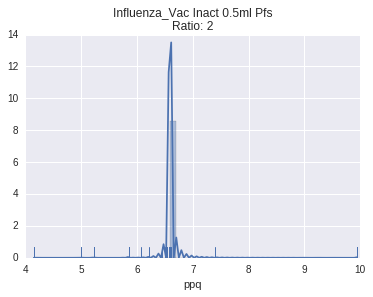

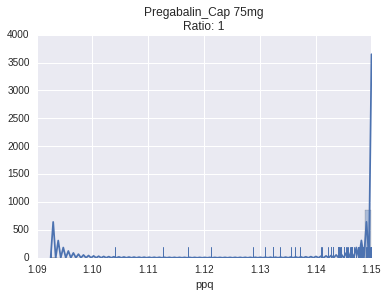

/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python2.7/dist-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


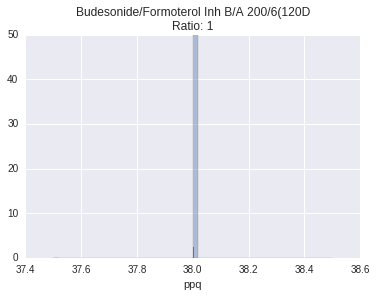

In [117]:
subjects = """0601060D0%	Glucose Blood Testing Reagents
0302000N0AABGBG	Fluticasone/Salmeterol_Inh 250/25mcg120D
1404000H0AAAFAF	Influenza_Vac Inact 0.5ml Pfs
0408010AEAAACAC	Pregabalin_Cap 75mg
0302000K0AAAMAM	Budesonide/Formoterol Inh B/A 200/6(120D"""
import sqlite3
con = sqlite3.connect("dmd.db")
for subject in subjects.split("\n"):
    code, title = subject.split("\t", 1)
    sql = """  SELECT
        *
      FROM
        ebmdatalab.tmp_eu.prescribing_sept
      WHERE
        bnf_code LIKE '%s'""" % code
    df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='standard')
    df['ppq'] = df['net_cost'] / df['quantity']
    df = df.sort_values('ppq')
    cheapest = float(df[['quantity', 'net_cost', 'ppq']].head(1)['ppq'].iloc[0])
    expensivest = float(df[['quantity', 'net_cost', 'ppq']].tail(1)['ppq'].iloc[0])
    ratio = int(expensivest / cheapest)
    sns.distplot(df['ppq'], rug=True)
    sns.plt.title("%s\nRatio: %s" % (title, ratio))
    sns.plt.show()


### 2. Some branded drugs that show significant variation 

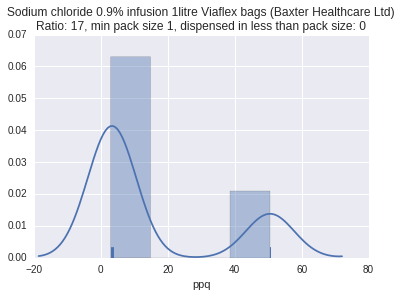

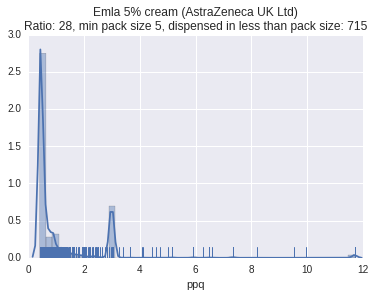

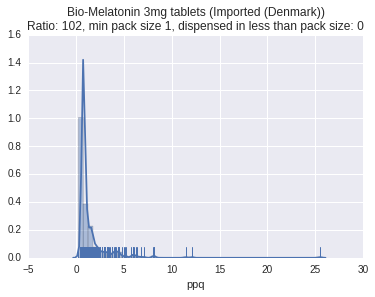

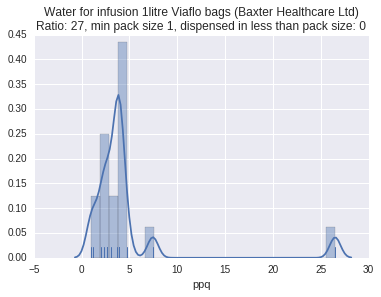

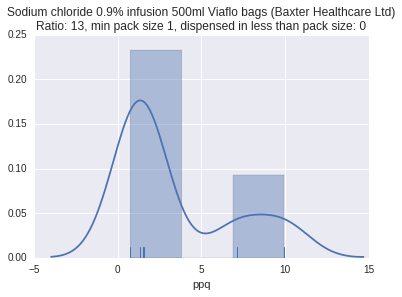

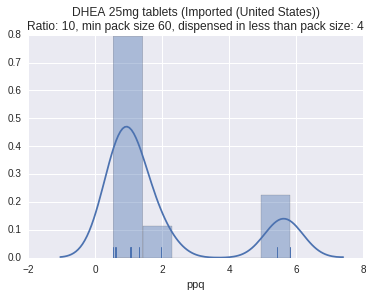

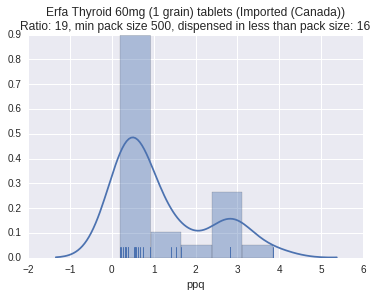

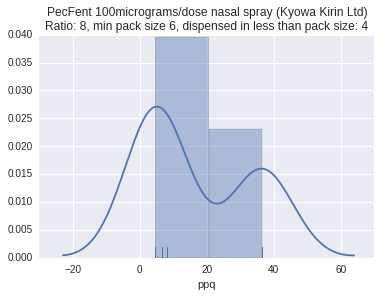

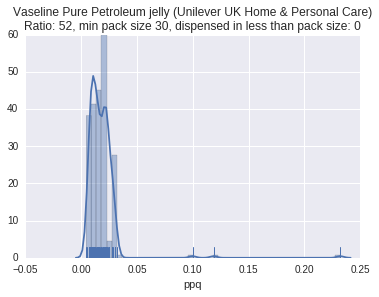

In [111]:
subjects = """0902021S0BBAJAZ	Sodium chloride 0.9% infusion 1litre Viaflex bags (Baxter Healthcare Ltd)
1502010J0BEAABY	Emla 5% cream (AstraZeneca UK Ltd)
0401010ADBCBZBP	Bio-Melatonin 3mg tablets (Imported (Denmark))
0902021X0BGACAZ	Water for infusion 1litre Viaflo bags (Baxter Healthcare Ltd)
0902021S0BBAXAY	Sodium chloride 0.9% infusion 500ml Viaflo bags (Baxter Healthcare Ltd)
0604030Q0BBAFAI	DHEA 25mg tablets (Imported (United States))
0602010Z0BEABAJ	Erfa Thyroid 60mg (1 grain) tablets (Imported (Canada))
0407020A0BPAABN	PecFent 100micrograms/dose nasal spray (Kyowa Kirin Ltd)
1302010N0BDAAAA	Vaseline Pure Petroleum jelly (Unilever UK Home & Personal Care)"""
import sqlite3
con = sqlite3.connect("dmd.db")
for subject in subjects.split("\n"):
    code, title = subject.split("\t", 1)
    sql = """  SELECT
        *
      FROM
        ebmdatalab.tmp_eu.prescribing_sept
      WHERE
        bnf_code = '%s'""" % code
    df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='standard')
    df['ppq'] = df['net_cost'] / df['quantity']
    df = df.sort_values('ppq')
    cheapest = float(df[['quantity', 'net_cost', 'ppq']].head(1)['ppq'].iloc[0])
    expensivest = float(df[['quantity', 'net_cost', 'ppq']].tail(1)['ppq'].iloc[0])
    ratio = int(expensivest / cheapest)

    sql = "select MIN(VMPP.QTYVAL) from dmd_product inner join AMP on dmd_product.DMDID = AMP.APID  inner join VMPP on AMP.VPID = VMPP.VPID where BNF_CODE = '%s'" % code
    min_pack_size = int(pd.read_sql_query(sql, con).iloc[0])
    dispensed_in_packs = len(df[df.quantity < min_pack_size])
    sns.distplot(df['ppq'], rug=True)
    sns.plt.title("%s\nRatio: %s, min pack size %s, dispensed in less than pack size: %s" % (title, ratio, min_pack_size, dispensed_in_packs))
    sns.plt.show()


### 3. Some NP8 drugs identified in our "scalping" exercise

See [this notebook](https://github.com/ebmdatalab/price-per-dose/blob/master/How%20would%20I%20scalp%20the%20NHS%3F.ipynb) for background

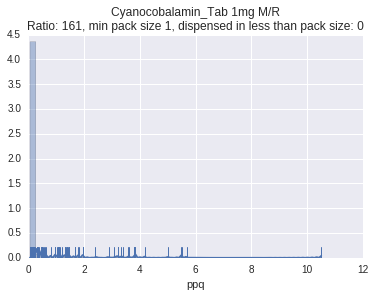

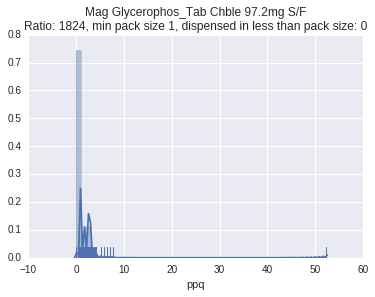

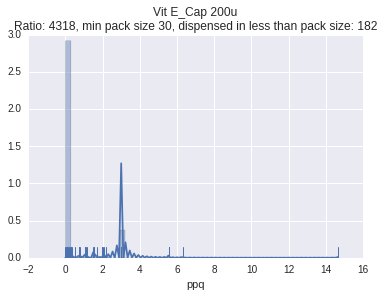

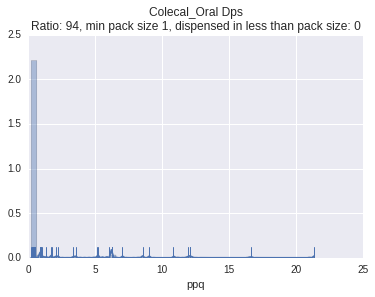

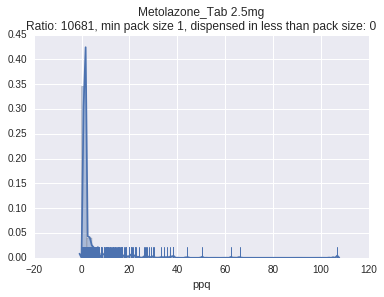

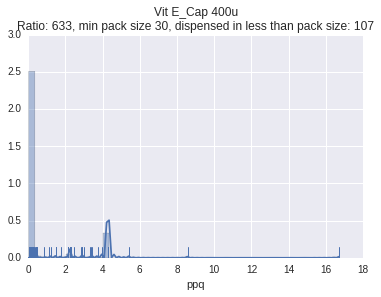

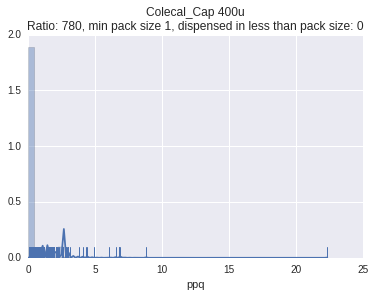

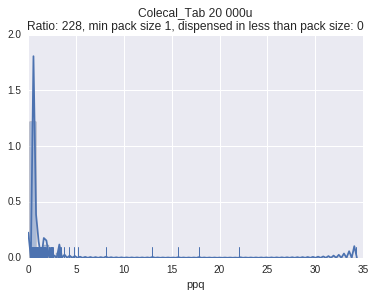

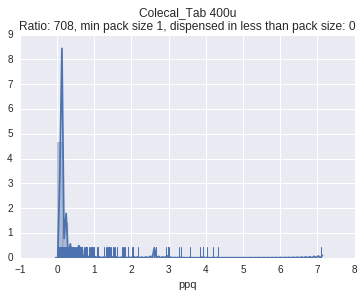

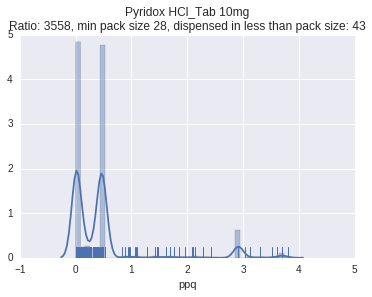

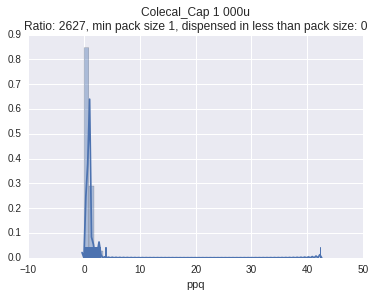

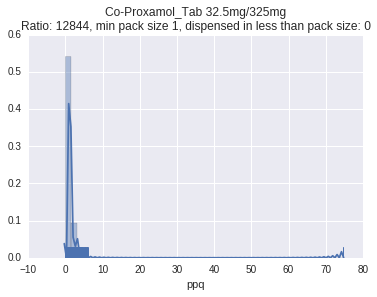

In [110]:
subjects = """0901020D0AAAHAH	Cyanocobalamin_Tab 1mg M/R
0905013G0AAAYAY	Mag Glycerophos_Tab Chble 97.2mg S/F
0906050P0AAABAB	Vit E_Cap 200u
0906040G0AABTBT	Colecal_Oral Dps
0202010V0AAANAN	Metolazone_Tab 2.5mg
0906050P0AAAFAF	Vit E_Cap 400u
0906040G0AABIBI	Colecal_Cap 400u
0906040G0AACRCR	Colecal_Tab 20 000u
0906040G0AABRBR	Colecal_Tab 400u
0906024N0AAAGAG	Pyridox HCl_Tab 10mg
0906040G0AABHBH	Colecal_Cap 1 000u
0407010Q0AAAAAA	Co-Proxamol_Tab 32.5mg/325mg"""

import sqlite3
con = sqlite3.connect("dmd.db")
for subject in subjects.split("\n"):
    code, title = subject.split("\t", 1)
    sql = """  SELECT
        *
      FROM
        ebmdatalab.tmp_eu.prescribing_sept
      WHERE
        bnf_code = '%s'""" % code
    df = pd.io.gbq.read_gbq(
        sql, project_id="ebmdatalab", verbose=False, dialect='standard')
    df['ppq'] = df['net_cost'] / df['quantity']
    df = df.sort_values('ppq')
    cheapest = float(df[['quantity', 'net_cost', 'ppq']].head(1)['ppq'].iloc[0])
    expensivest = float(df[['quantity', 'net_cost', 'ppq']].tail(1)['ppq'].iloc[0])
    ratio = int(expensivest / cheapest)

    sql = "select MIN(VMPP.QTYVAL) from dmd_product inner join AMP on dmd_product.DMDID = AMP.APID  inner join VMPP on AMP.VPID = VMPP.VPID where BNF_CODE = '%s'" % code
    min_pack_size = int(pd.read_sql_query(sql, con).iloc[0])
    dispensed_in_packs = len(df[df.quantity < min_pack_size])
    sns.distplot(df['ppq'], rug=True)
    sns.plt.title("%s\nRatio: %s, min pack size %s, dispensed in less than pack size: %s" % (title, ratio, min_pack_size, dispensed_in_packs))
    sns.plt.show()